# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

The United States of Ameica is the country with one of the largest immigrant population in the world. After the IT boom ,  this immigration in recent times has been driven by IT workers from Asia coming into  the states. A large number of them belong to India which due to its high population and eductational sysytem is able to provide one of the cheapest most talented manpower for IT firms. Indians flock by the 1000's to America chasing the American Dream. This has led to a growth of new markets being created that caters to the immigrated folk. One of the most lucrative ones of them being the Indian restaurant business. Indian cooking is know across the world for its diverse flavours and spices . Both Indians and American Nationals alike have taken a great fondness to the Indian Cuisine.  This has led to a spurt in the Indian restaurant business. These businessess have specifically targeted places with large Indian population earlier but due to market saturation have started moving away to other parts.

In this project we will try to find an optimal location for an India restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Indian restaurant** in **Manhattan , New York**, USA.

Since there are lots of restaurants in New York we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no Indian restaurants in vicinity**. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### IMPORTING DEPENDENCIES 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab
usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


##  Download and Explore Dataset


Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a _pandas_ dataframe


In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Neighbourhoods in each borrough 

In [8]:
neighborhoods['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

#### Use geopy library to get the latitude and longitude values of New York City.


In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### Visualizing a map of Manhattan

In [15]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### INITIALIZE FOURAQUARE API 

In [10]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'Your Foursquare ID '
CLIENT_SECRET = 'Your Secret Key '
VERSION = '20201209'

In [11]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

#### Getting the venues in Manhattan within a radius of 1000 m 

In [12]:
 
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues_north_indian = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000)
newyork_venues_north_indian.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   
2  Marble Hill              40.876551               -73.91066   
3  Marble Hill              40.876551               -73.91066   
4  Marble Hill              40.876551               -73.91066   

                Venue  Venue Latitude  Venue Longitude      Venue Category  
0  Marble Hill Unisex       40.877389       -73.909283  Salon / Barbershop  
1      Wine & Liquors       40.874833       -73.909956           Wine Shop  
2   Hernandez Grocery       40.875965       -73.912994       Deli / Bodega  
3    St. Stephens UMC       40.876967       -73.909106              Church  
4             Dunkin'       40.879296       -73.905135          Donut Shop

In [13]:
newyork_venues_north_indian.shape


(3977, 7)

#### Taking a look at the most common places in Manhattan

In [16]:
manhattan_venues = newyork_venues_north_indian.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
manhattan_venues.head()

Venue Category  Count
0  Residential Building (Apartment / Condo)    274
1                                    Office    250
2                                  Building    170
3                           Doctor's Office    125
4                        Salon / Barbershop    107

#### Filtering to take a look at India Restaurants in Brooklyn 

In [17]:
manhattan_indian = newyork_venues_north_indian[newyork_venues_north_indian['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
manhattan_indian

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       East Harlem              40.792249              -73.944182   
1        Lenox Hill              40.768113              -73.958860   
2           Chelsea              40.744035              -74.003116   
3           Tribeca              40.721522              -74.010683   
4  Manhattan Valley              40.797307              -73.964286   

                              Venue  Venue Latitude  Venue Longitude  \
0                    Om Indian Food       40.792014       -73.945332   
1  Rangoli Exquisite Indian Cuisine       40.769428       -73.958382   
2                 Dil-e Punjab Deli       40.744845       -74.002528   
3                           Paisley       40.722307       -74.009397   
4                    Roasted Masala       40.798433       -73.963708   

      Venue Category  
0  Indian Restaurant  
1  Indian Restaurant  
2  Indian Restaurant  
3  Indian Restaurant  
4  Indian Restaurant

#### One Hot Encoding 

In [18]:
ny_onehot = pd.get_dummies(newyork_venues_north_indian[['Venue Category']], prefix="", prefix_sep="")   # Using dummies to Encode
ny_onehot['Neighborhood'] = newyork_venues_north_indian['Neighborhood']

fixed_columns = [ny_onehot.columns[182]] + list(ny_onehot.columns[:182]) + list(ny_onehot.columns[183:])  # Getting the Neighborhoods column to the first
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(3977, 394)


Harbor / Marina  Accessories Store  Acupuncturist  Adult Boutique  \
0                0                  0              0               0   
1                0                  0              0               0   
2                0                  0              0               0   
3                0                  0              0               0   
4                0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  \
0                   0                  0                   0   
1                   0                  0                   0   
2                   0                  0                   0   
3                   0                  0                   0   
4                   0                  0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    0               0             0       0   
1                    0               0             0       0   
2                    0               0             0       0   
3                    0               0             0       0   
4                    0               0             0       0   

   Arepa Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0            0           0                    0   
1                 0            0           0                    0   
2                 0            0           0                    0   
3                 0            0           0                    0   
4                 0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Assisted Living  Astrologer  \
0                     0                 0                0           0   
1                     0                 0                0           0   
2                     0                 0                0           0   
3                     0                 0                0           0   
4                     0                 0                0           0   

   Athletics & Sports  Auditorium  Auto Dealership  Auto Garage  \
0                   0           0                0            0   
1                   0           0                0            0   
2                   0           0                0            0   
3                   0           0                0            0   
4                   0           0                0            0   

   Auto Workshop  Automotive Shop  Bagel Shop  Bakery  Bank  Bar  \
0              0                0           0       0     0    0   
1              0                0           0       0     0    0   
2              0                0           0       0     0    0   
3              0                0           0       0     0    0   
4              0                0           0       0     0    0   

   Baseball Field  Basketball Court  Bath House  Beach  Bed & Breakfast  \
0               0                 0           0      0                0   
1               0                 0           0      0                0   
2               0                 0           0      0                0   
3               0                 0           0      0                0   
4               0                 0           0      0                0   

   Beer Bar  Beer Garden  Bike Rental / Bike Share  Bike Shop  Bistro  \
0         0            0                         0          0       0   
1         0            0                         0          0       0   
2         0            0                         0          0       0   
3         0            0                         0          0       0   
4         0            0                         0          0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Boxing Gym  Breakfast Spot  \
0           0              0          0         0           0               0   
1           0              0          0         0           0               

#### Grouping the Categories

In [19]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()  # Grouping and taking the mean
print(ny_grouped.shape)
ny_grouped.head()

(40, 394)


Neighborhood  Harbor / Marina  Accessories Store  Acupuncturist  \
0  Battery Park City         0.031579           0.000000       0.000000   
1      Carnegie Hill         0.000000           0.009091       0.018182   
2     Central Harlem         0.009009           0.000000       0.000000   
3            Chelsea         0.000000           0.000000       0.000000   
4          Chinatown         0.000000           0.008197       0.000000   

   Adult Boutique  Advertising Agency  Afghan Restaurant  African Restaurant  \
0             0.0                 0.0                0.0            0.000000   
1             0.0                 0.0                0.0            0.000000   
2             0.0                 0.0                0.0            0.000000   
3             0.0                 0.0                0.0            0.000000   
4             0.0                 0.0                0.0            0.008197   

   American Restaurant  Animal Shelter  Antique Shop    Arcade  \
0             0.010526             0.0      0.000000  0.010526   
1             0.000000             0.0      0.000000  0.000000   
2             0.000000             0.0      0.000000  0.009009   
3             0.000000             0.0      0.009901  0.000000   
4             0.000000             0.0      0.000000  0.000000   

   Arepa Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0          0.000000     0.010526         0.0             0.000000   
1          0.000000     0.018182         0.0             0.000000   
2          0.000000     0.009009         0.0             0.000000   
3          0.009901     0.039604         0.0             0.000000   
4          0.000000     0.008197         0.0             0.008197   

   Arts & Entertainment  Asian Restaurant  Assisted Living  Astrologer  \
0              0.000000          0.000000         0.000000         0.0   
1              0.000000          0.009091         0.009091         0.0   
2              0.000000          0.000000         0.000000         0.0   
3              0.019802          0.000000         0.000000         0.0   
4              0.008197          0.016393         0.000000         0.0   

   Athletics & Sports  Auditorium  Auto Dealership  Auto Garage  \
0            0.000000         0.0         0.000000          0.0   
1            0.000000         0.0         0.000000          0.0   
2            0.000000         0.0         0.000000          0.0   
3            0.000000         0.0         0.009901          0.0   
4            0.016393         0.0         0.000000          0.0   

   Auto Workshop  Automotive Shop  Bagel Shop    Bakery      Bank       Bar  \
0            0.0         0.000000    0.010526  0.000000  0.010526  0.021053   
1            0.0         0.000000    0.000000  0.009091  0.009091  0.000000   
2            0.0         0.009009    0.000000  0.000000  0.000000  0.009009   
3            0.0         0.009901    0.000000  0.000000  0.009901  0.000000   
4            0.0         0.000000    0.000000  0.032787  0.008197  0.000000   

   Baseball Field  Basketball Court  Bath House  Beach  Bed & Breakfast  \
0             0.0               0.0         0.0    0.0              0.0   
1             0.0               0.0         0.0    0.0              0.0   
2             0.0               0.0         0.0    0.0              0.0   
3             0.0               0.0         0.0    0.0              0.0   
4             0.0               0.0         0.0    0.0              0.0   

   Beer Bar  Beer Garden  Bike Rental / Bike Share  Bike Shop    Bistro  \
0  0.000000          0.0                  0.010526   0.000000  0.010526   
1  0.000000          0.0                  0.000000   0.000000  0.000000   
2  0.000000          0.0                  0.000000   0.000000  0.000000   
3  0.009901          0.0                  0.000000   0.000000  0.000000   
4  0.000000          0.0                  0.008197   0.016393  0.000000   

   Board Shop  Boat or Ferry  Bookstore

In [38]:
grouped_indian = ny_grouped[['Neighborhood','Indian Restaurant']]  # Only Indian Restaurant needs to be considered
grouped_indian

Neighborhood  Indian Restaurant
0     Battery Park City           0.000000
1         Carnegie Hill           0.000000
2        Central Harlem           0.000000
3               Chelsea           0.009901
4             Chinatown           0.000000
5          Civic Center           0.000000
6               Clinton           0.000000
7           East Harlem           0.012195
8          East Village           0.000000
9    Financial District           0.000000
10             Flatiron           0.000000
11             Gramercy           0.000000
12    Greenwich Village           0.000000
13     Hamilton Heights           0.000000
14         Hudson Yards           0.000000
15               Inwood           0.000000
16           Lenox Hill           0.008772
17       Lincoln Square           0.000000
18         Little Italy           0.000000
19      Lower East Side           0.000000
20     Manhattan Valley           0.071429
21       Manhattanville           0.000000
22          Marble Hill           0.000000
23              Midtown           0.000000
24        Midtown South           0.000000
25  Morningside Heights           0.000000
26          Murray Hill           0.000000
27                 Noho           0.000000
28     Roosevelt Island           0.000000
29                 Soho           0.000000
30      Stuyvesant Town           0.000000
31         Sutton Place           0.000000
32              Tribeca           0.009524
33           Tudor City           0.000000
34           Turtle Bay           0.000000
35      Upper East Side           0.000000
36      Upper West Side           0.000000
37   Washington Heights           0.000000
38         West Village           0.000000
39            Yorkville           0.000000

#### Clustering

### Using Elbow method to determine best k 

In [21]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) # Range of k-values
    KM.fit(grouped_indian.drop(columns=['Neighborhood'])) 
    cost.append(KM.inertia_)     # Getting the cost

<ipython-input-21-8f5683f53afc>:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  KM.fit(grouped_indian.drop(columns=['Neighborhood']))
<ipython-input-21-8f5683f53afc>:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  KM.fit(grouped_indian.drop(columns=['Neighborhood']))
<ipython-input-21-8f5683f53afc>:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  KM.fit(grouped_indian.drop(columns=['Neighborhood']))
<ipython-input-21-8f5683f53afc>:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  KM.fit(grouped_indian.drop(columns=['Neighborhood']))


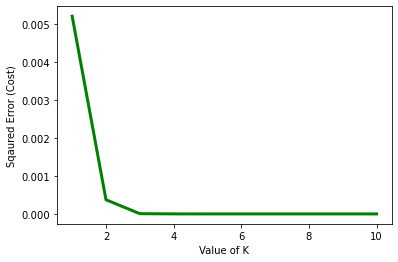

In [22]:
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [23]:
kclusters = 3     # No.of Clusters
ny_grouped_clustering = grouped_indian.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 2, 0, 0, 0, 2, 0, 0])

In [24]:
grouped = grouped_indian.copy(deep=True)
grouped['Cluster Labels'] = kmeans.labels_    # Adding the labels to the data
grouped['Cluster Labels'] = grouped['Cluster Labels'].astype(int)  # Float is sometimes returned
print(grouped.shape)
grouped.head(10)

(40, 3)


Neighborhood  Indian Restaurant  Cluster Labels
0   Battery Park City           0.000000               0
1       Carnegie Hill           0.000000               0
2      Central Harlem           0.000000               0
3             Chelsea           0.009901               2
4           Chinatown           0.000000               0
5        Civic Center           0.000000               0
6             Clinton           0.000000               0
7         East Harlem           0.012195               2
8        East Village           0.000000               0
9  Financial District           0.000000               0

In [25]:
to_merged = grouped.join(newyork_venues_north_indian.set_index("Neighborhood"), on="Neighborhood") # Merge with the original data
print(to_merged.shape)
to_merged.head()

(3977, 9)


Neighborhood  Indian Restaurant  Cluster Labels  \
0  Battery Park City                0.0               0   
0  Battery Park City                0.0               0   
0  Battery Park City                0.0               0   
0  Battery Park City                0.0               0   
0  Battery Park City                0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              40.711932              -74.016869   
0              40.711932              -74.016869   
0              40.711932              -74.016869   
0              40.711932              -74.016869   
0              40.711932              -74.016869   

                           Venue  Venue Latitude  Venue Longitude  \
0                 Sirius Dog Run       40.712067       -74.016902   
0  New York City Police Memorial       40.712034       -74.016659   
0       Piece Of The Berlin Wall       40.711723       -74.016720   
0                  Gateway Plaza       40.711681       -74.016921   
0          Merchants River House       40.711403       -74.017930   

                             Venue Category  
0                                   Dog Run  
0                       Monument / Landmark  
0                             Historic Site  
0  Residential Building (Apartment / Condo)  
0                       American Restaurant

#### Visualizing the Clusters

In [26]:
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
to_merged[to_merged['Cluster Labels']==0]  # Cluster 0

Neighborhood  Indian Restaurant  Cluster Labels  \
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0               0   
0     Battery Park City                0.0 

In [28]:
to_merged[to_merged['Cluster Labels']==1]  # Cluster 1

Neighborhood  Indian Restaurant  Cluster Labels  \
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   
20  Manhattan Valley           0.071429               1   

    Neighborhood Latitude  Neighborhood Longitude  \
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   
20              40.797307              -73.964286   

                                                Venue  Venue Latitude  \
20  The Children's Aid Society- Frederick Douglass...       40.797662   
20                                 Sammy Deli Grocery       40.798035   
20                                           The Bird       40.797377   
20                                          PAYOMATIC       40.800020   
20                                     Roasted Masala       40.798433   
20                              Parkside Gourmet Deli       40.798141   
20                                      empire garden       40.798274   
20                                 Park West Cleaners       40.797953   
20                                 Maria’s Hair Salon       40.798134   
20                                         The Empire       40.798255   
20                                         SLR Jitney       40.796834   
20                                   Jose Barber Shop       40.798280   
20                                   60 Manhattan Ave       40.796425   
20                                A Kimpton Apartment       40.798035   

    Venue Longitude                            Venue Category  
20       -73.963853                                  Building  
20       -73.963469                             Deli / Bodega  
20       -73.963725                                  Building  
20       -73.935909                     Check Cashing Service  
20       -73.963708                         Indian Restaurant  
20       -73.963959                             Deli / Bodega  
20       -73.963267                        Chinese Restaurant  
20       -73.963424                           Laundry Service  
20       -73.963605                        Salon / Barbershop  
20       -73.963667                              Trailer Park  
20       -73.964622                                  Bus Line  
20       -73.963583                        Salon / Barbershop  
20       -73.962770                                  Building  
20       -73.963469  Residential Building (Apartment / Condo)

In [29]:
to_merged[to_merged['Cluster Labels']==2]  # Cluster 2

Neighborhood  Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   
3       Chelsea           0.009901               2              40.744035   

In [30]:
t = to_merged[to_merged['Cluster Labels']==0]
print('Number of Indian Restaurants in Cluster 0: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==1]
print('Number of Indian Restaurants in Cluster 1: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==2]
print('Number of Indian Restaurants in Cluster 2: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))

Number of Indian Restaurants in Cluster 0: 0
Number of Indian Restaurants in Cluster 1: 1
Number of Indian Restaurants in Cluster 2: 4


#### Cluster 0 ideal as no indian restaurant 

In [39]:
temp = to_merged[to_merged['Cluster Labels']==0]
x = temp[temp['Venue Category'].str.contains('Restaurant')].groupby(['Neighborhood','Venue Category']).count()
y = x.reset_index().rename(columns={'Venue':'Count'})[['Neighborhood','Venue Category','Count']].sort_values(by='Count',ascending=False).reset_index(drop=True).head(6)
y.head(10)

Neighborhood       Venue Category  Count
0       Little Italy   Italian Restaurant     22
1          Chinatown   Chinese Restaurant      9
2            Clinton           Restaurant      5
3  Greenwich Village   Italian Restaurant      4
4      Midtown South  American Restaurant      4
5      Carnegie Hill   Mexican Restaurant      3

#### Exploring Cluster 0 as most ideal Cluster -   Most Common Venues in Cluster 0 

In [32]:
temp.groupby('Venue Category').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Venue Category','Count']].sort_values('Count',ascending=False).reset_index(drop=True).head(10)

Venue Category  Count
0  Residential Building (Apartment / Condo)    250
1                                    Office    238
2                                  Building    145
3                           Doctor's Office    119
4                        Salon / Barbershop     94
5                           Laundry Service     54
6                             Deli / Bodega     52
7                               Art Gallery     52
8                              Tech Startup     51
9                                Food Truck     42

In [33]:
clus_0  = to_merged[to_merged['Cluster Labels']==0].groupby('Neighborhood').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Neighborhood','Count']].sort_values('Count',ascending=False).reset_index(drop=True)
print('Number of Neighborhoods: {}'.format(len(clus_0)))
clus_0.head()

Number of Neighborhoods: 35


Neighborhood  Count
0             Flatiron    131
1  Morningside Heights    122
2            Chinatown    122
3   Financial District    119
4         West Village    117

#### Cluster 1 rejected as not many restaurants there

In [34]:
temp = to_merged[to_merged['Cluster Labels']==1]
x = temp[temp['Venue Category'].str.contains('Restaurant')].groupby(['Neighborhood','Venue Category']).count()
y = x.reset_index().rename(columns={'Venue':'Count'})[['Neighborhood','Venue Category','Count']].sort_values(by='Count',ascending=False).reset_index(drop=True).head(6)
y

Neighborhood      Venue Category  Count
0  Manhattan Valley  Chinese Restaurant      1
1  Manhattan Valley   Indian Restaurant      1

In [35]:
temp = to_merged[to_merged['Cluster Labels']==2]
x = temp[temp['Venue Category'].str.contains('Restaurant')].groupby(['Neighborhood','Venue Category']).count()
y = x.reset_index().rename(columns={'Venue':'Count'})[['Neighborhood','Venue Category','Count']].sort_values(by='Count',ascending=False).reset_index(drop=True).head(6)
y

Neighborhood       Venue Category  Count
0      Tribeca  American Restaurant      3
1   Lenox Hill    Afghan Restaurant      2
2   Lenox Hill   Italian Restaurant      2
3   Lenox Hill  American Restaurant      1
4      Tribeca     Sushi Restaurant      1
5      Tribeca    Indian Restaurant      1